# Campaign Effect Estimation in Observational Data Using Causal Inference Methods

This notebook demonstrates how to analyze causal effects in marketing campaigns based on observational data. 

### Use Case
We consider a scenario where selected customers were provided (treated) with personalized offers. We do not assume that proper A/B testing was done, so we just study the observational data. Our goal is to measure the treatment effect of these offers on conversions (purchases) taking into account factors such as demographics that influence both offer assignments and customers' purchasing decisions. 

### Prototype: Approach and Data
We use generated data (simulator) to demonstrate the causal inference methods in a clean way. We simulate a simple promotion campaign scenario and then use regression and propensity matching methods to estimate the treatment effect. 

### Usage and Productization
This prototype can be used to evaluate causal effects in a real data sample before building predictive promotion targeting or budget optimization models. This template can also be adapted to a wide range of customer communication and personalization scenarios.

It is recommended to start with modifying the data generator to match your use case and data samples. Once the generator is modified, different inference methods can be evaluated and fine-tuned using simulations. Once we are confident that the methods produce valid results for simulated data, we can apply them to the actual data sample.

# Data Generation

We use a basic data generation model with the following variables:
 - `age` - observed customer demographics variable
 - `state` - observed customer demographics variable
 - `is_offer` - indicates customers who were targeted with a special offer  
 - `is_conversion` - indicates conversion after a promotion campaign
    
Both targeting decisions (`is_offer`) and conversions (`is_conversion`) are dependent on demographics. In other words, the demographic variables are the back doors. 

We provide several visualizations that help to understand the correlation between the variables. In particular, these visualization indicate that offers and conversions are positively correlated. This is true even if the `promo_effect` parameter is set to zero. Our goal will be to estimate the real causal effect of the offers on conversions controlling for the back doors.

In [18]:
#
# Imports and settings
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler

import statsmodels.formula.api as smf
from dowhy import CausalModel

+----+-------+---------+------------+-----------------+
|    |   age | state   | is_offer   | is_conversion   |
|----+-------+---------+------------+-----------------|
|  0 |    30 | TX      | False      | True            |
|  1 |    28 | TX      | False      | False           |
|  2 |    31 | TX      | False      | False           |
|  3 |    29 | TX      | False      | False           |
|  4 |    25 | TX      | False      | False           |
+----+-------+---------+------------+-----------------+
+--------+-------------+---------+------------+-----------------+
|        |         age | state   |   is_offer |   is_conversion |
|--------+-------------+---------+------------+-----------------|
| count  | 100000      | 100000  |     100000 |          100000 |
| unique |    nan      | 3       |          2 |               2 |
| top    |    nan      | NJ      |          0 |               0 |
| freq   |    nan      | 33461   |      67312 |           79570 |
| mean   |     28.0038 | nan     |

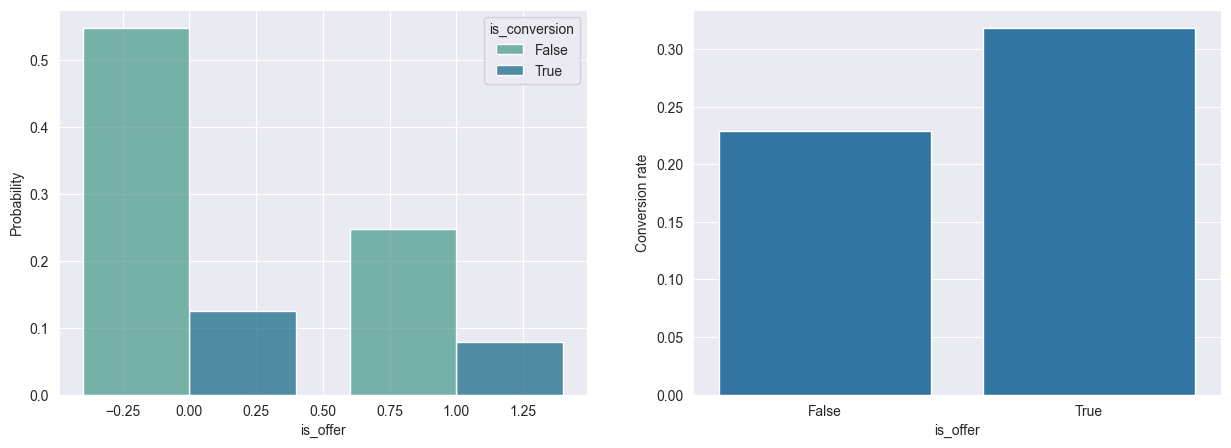

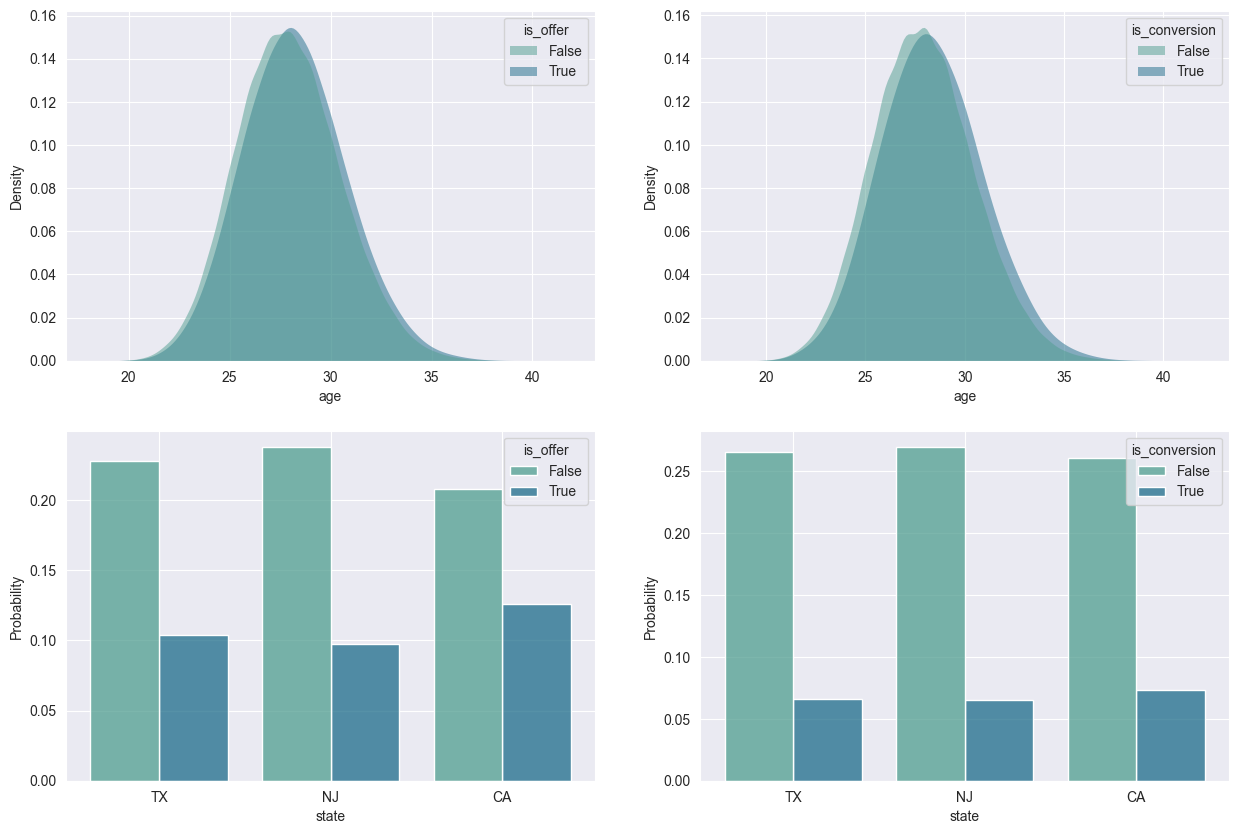

In [22]:
def print_df(df):
    print(tabulate(df, headers='keys', tablefmt='psql'))

def generate_promotion_data(promo_effect = 0.05, state_effect = 0.02, age_effect = 0.2, n = 100000, rnd_seed = 42):
    
    rng = np.random.default_rng(rnd_seed)
    
    # Demographic features
    data = pd.DataFrame({
        'age': 20 + rng.binomial(40, 0.2, n),
        'state': rng.choice(['CA', 'NJ', 'TX'], n)
    })
    data['age_std'] = MinMaxScaler().fit_transform(np.array(data['age']).reshape(-1,1))

    # Historical promotion campaigns: the offers were targeted based on demographics
    data['is_offer'] = rng.uniform(size = n) < (
            0.20 +
            0.10 * (data['state'] == 'CA') +
            0.03 * (data['state'] == 'TX') +
            0.01 * (data['state'] == 'NJ') +
            0.20 * (data['age_std'])
    )

    # Outcome depends both on offer and demographic
    data['is_conversion'] = rng.uniform(size = n) < (
            0.10 +
            promo_effect * data['is_offer'] +
            state_effect * (data['state'] == 'CA') +
            age_effect   * (data['age_std'])
    )
    
    data.drop(columns=['age_std'], inplace=True)
    
    return data

data = generate_promotion_data()

#
# Dataset preview and descriptive statistics
#
print_df(data.head(5))
print_df(data.describe(include='all')) 


#
# Visualize the correlation between offers and conversion rates
#
_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=data, x="is_offer", hue="is_conversion", palette="crest", 
             stat="probability", multiple="dodge", shrink=.8, discrete=True, ax=ax[0])
crosstab = pd.crosstab(data["is_offer"], data["is_conversion"])
offer_conversion_rate = crosstab.iloc[:, 1] / crosstab.iloc[:, 0]
sns.barplot(offer_conversion_rate, ax=ax[1])
plt.ylabel("Conversion rate")


#
# Visualize the distributions
#
_, ax = plt.subplots(2, 2, figsize=(15, 10))
for j, y in enumerate(['is_offer', 'is_conversion']):
    sns.kdeplot(
        data=data, x="age", hue=y, bw_adjust=2,
        fill=True, common_norm=False, palette="crest",
        alpha=.5, linewidth=0, ax=ax[0][j]
    )
    sns.histplot(
        data=data, x="state", hue=y, shrink=.8, palette="crest", 
        stat="probability", multiple="dodge", ax=ax[1][j]
    )

# Solution 1: Promotion Effect Estimation Using Regression 

In this section, we start with estimating the average treatment effect (ATE) using a manually implemented regression to control for back doors. We then use an off-the-shelf library method to achieve the same.

In [41]:
data = generate_promotion_data(promo_effect=0.3, age_effect=0.0)

def get_logit_model(data: pd.DataFrame):
    #
    # Feature engineering
    #
    df = data.copy()
    df['is_offer'] = 1*df['is_offer']
    df['is_conversion'] = 1*df['is_conversion']
    df['age'] = MinMaxScaler().fit_transform(np.array(df['age']).reshape(-1,1))

    #
    # Model fitting 
    #
    model_logit = smf.logit("is_conversion ~ is_offer + C(state) + age", data=df).fit(disp=0) 
    
    return model_logit, df

#
# Create a model and perform diagnostics. The estimated marginal effect should 
# match the true effect specified in the data generator.
#
logit_model, _ = get_logit_model(data)
print(logit_model.summary())
print(logit_model.get_margeff().summary())

                           Logit Regression Results                           
Dep. Variable:          is_conversion   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99995
Method:                           MLE   Df Model:                            4
Date:                Sun, 07 Jan 2024   Pseudo R-squ.:                  0.1183
Time:                        07:27:23   Log-Likelihood:                -44918.
converged:                       True   LL-Null:                       -50946.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.0747      0.031    -66.427      0.000      -2.136      -2.013
C(state)[T.NJ]    -0.1353      0.020     -6.629      0.000      -0.175      -0.095
C(state)[T.TX]    -0.1121      0.020

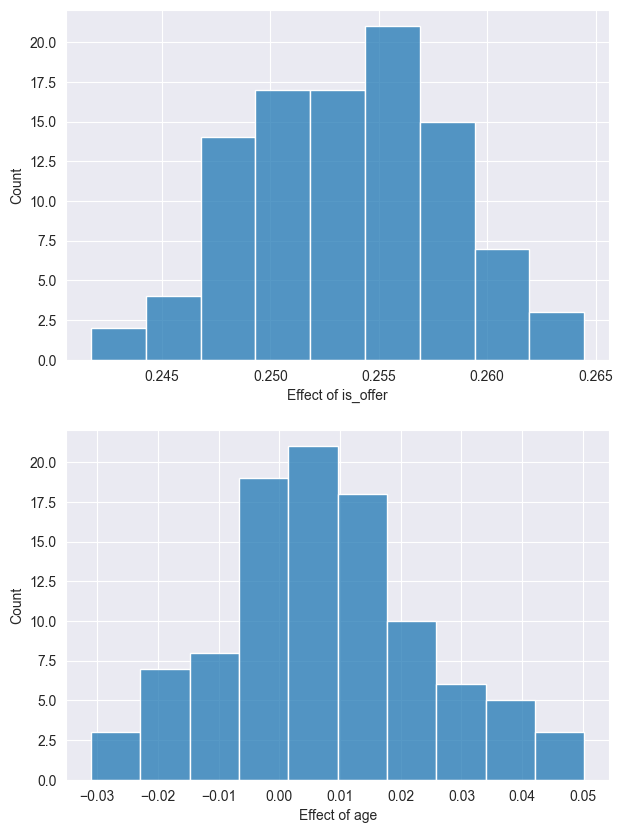

In [42]:
#
# Evaluate the distribution of the effect using bootstrapping
#
_, ax = plt.subplots(2, 1, figsize=(7, 10))
for j, x in enumerate(['is_offer', 'age']):
    effect = []
    for i in range(100):
        df = data.sample(frac=0.2) # bootstrapping
        logit_model, _ = get_logit_model(df)
        effect.append(logit_model.get_margeff().summary_frame()['dy/dx'][x])

    sns.histplot(effect, ax=ax[j])
    ax[j].set_xlabel(f"Effect of {x}")

In [47]:
#
# Estimate the is_offer->is_conversion effect using a library methods
#
graph = """digraph {
    is_offer->is_conversion; 
    age->is_conversion; 
    age->is_offer; 
    state->is_conversion; 
    state->is_offer;
}"""
df = data[['age', 'state', 'is_conversion', 'is_offer']].copy()
model = CausalModel(
    data=df,
    treatment='is_offer',
    outcome='is_conversion',
    graph=graph)

# Identify causal effect and return target estimands
identified_estimand = model.identify_effect()

# Estimate the target estimand using a statistical method.
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        confidence_intervals=True,
        test_significance=True)
print(causal_estimate_reg)
print(f"Causal Estimate is {causal_estimate_reg.value:.3}")

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                 
───────────(E[is_conversion|state,age])
d[is_offer]                            
Estimand assumption 1, Unconfoundedness: If U→{is_offer} and U→is_conversion then P(is_conversion|is_offer,state,age,U) = P(is_conversion|is_offer,state,age)

## Realized estimand
b: is_conversion~is_offer+state+age
Target units: ate

## Estimate
Mean value: 0.30579888971335434
p-value: [0.]
95.0% confidence interval: [[0.30077753 0.31082025]]

Causal Estimate is 0.306


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


# Solution 2: Promotion Effect Estimation Using Propensity Scoring

In this section, we  estimate the average treatment effect using propensity score matching/weighting. We use the model fitted in the previous section.

In [44]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_weighting",
                                 confidence_intervals=True,
                                 target_units="ate")

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                 
───────────(E[is_conversion|state,age])
d[is_offer]                            
Estimand assumption 1, Unconfoundedness: If U→{is_offer} and U→is_conversion then P(is_conversion|is_offer,state,age,U) = P(is_conversion|is_offer,state,age)

## Realized estimand
b: is_conversion~is_offer+state+age
Target units: ate

## Estimate
Mean value: 0.30574958545302766
95.0% confidence interval: (0.2996564731485418, 0.31120974532863077)
